In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM,TimeDistributed, Lambda, Flatten, SimpleRNN
from tensorflow.keras.utils import plot_model
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/PRACA_INŻYNIERSKA_DANE/PREPROCESSED_DATA/WEYS.csv'
# df = pd.read_csv(path)
df = pd.read_csv(path,  sep=',')
#skiprows=range(1, 12),

In [ ]:
#hipoteza pominac 2008 czyli 12 pierwszych wierszy
df.head(25)

,Unnamed: 0,timestamp,avg_price
0,0,2008-01-02,27.202892
1,1,2008-01-03,26.982058
2,2,2008-01-04,26.656711
3,3,2008-01-05,27.063863
4,4,2008-01-06,27.471014
5,5,2008-01-07,27.878166
6,6,2008-01-08,27.794297
7,7,2008-01-09,27.734126
8,8,2008-01-10,28.860389
9,9,2008-01-11,27.356992


In [ ]:
df.describe()

,Unnamed: 0,avg_price
count,5014.000000,5014.000000
mean,2506.500000,25.918024
std,1447.561455,3.928244
min,0.000000,15.329356
25%,1253.250000,23.289992
50%,2506.500000,25.776001
75%,3759.750000,28.047987
max,5013.000000,38.958743


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5014 entries, 0 to 5013
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5014 non-null   int64  
 1   timestamp   5014 non-null   object 
 2   avg_price   5014 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 117.6+ KB


In [ ]:
df.avg_price.value_counts()

28.057477    1
23.934106    1
24.034740    1
27.605512    1
27.287982    1
            ..
35.839470    1
31.685085    1
31.772705    1
28.348859    1
22.289165    1
Name: avg_price, Length: 5014, dtype: int64

In [ ]:
df[df.avg_price == 1.65]

,Unnamed: 0,timestamp,avg_price


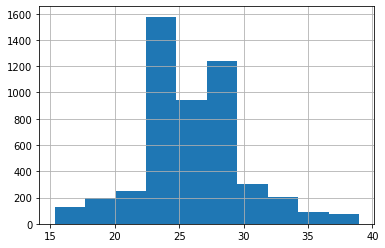

In [ ]:
df.avg_price.hist()

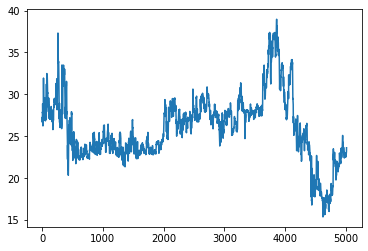

In [ ]:
df.avg_price.plot()

In [ ]:
def preprocess(df: pd.DataFrame):
   # df on input should contain only one column with the price data (plus dataframe index)
    df = df['avg_price']
    min = df.min()
    max = df.max()
    x = df 
    # time series normalization part
    # y will be a column in a dataframe
    y = (x - min) / (max - min)

    #other allements t o add if needed
    return y, min, max

In [ ]:
WINDOW_SIZE = 12*30 # 2 seconds
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
STEPS_AHEAD = 3*30

In [ ]:
test_split = 0.2
#skiprows=range(1, 12),
df = pd.read_csv(path,  sep=',')
len = df.shape[0]
split_point = int(len * (1 - test_split))
# splitting dataframe by row index
train = df.iloc[:split_point,:]
test = df.iloc[split_point-WINDOW_SIZE:,:]

train, min, max = preprocess(train)

test = test.avg_price
test = (test - min) / (max - min)



In [ ]:
#funkcja do przetwarzania danych i wczytywania do pamięci
def windowed_dataset(ds:tf.data.Dataset, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  #podzial na okna - z 'odcieciem' konca pliku
#okna długości rok i 90 dni
  ds = ds.window(window_size + STEPS_AHEAD, shift=1, drop_remainder=True)
    #w każdym punkcie pojawia się nowe okno (shift=1)
    #ostatnie wskazania nie są wycinkami tego wycinka (okno byłoby na krótkie - drop_remainder=true)
  ds = ds.flat_map(lambda w: w.batch(window_size + STEPS_AHEAD)) #usuwanie nadmiarowych nawiasów
  #x i y
  #x to cały wycinek poza wartością predykowaną, y są wartości predykowane
  #num_parallel_calls=AUTOTUNE - wykonywanie wielowątkowe i pakowanie w paczki i mieszane
  ds = ds.map(lambda w: (w[:-STEPS_AHEAD].reshape(-1,1), w[-STEPS_AHEAD:]), 
              num_parallel_calls=AUTOTUNE)
  return ds.shuffle(100).batch(batch_size)


#funkcja do wczytywania pliku
def csv_reader_dataset(df, repeat=None, batch_size=32):
  #bierze potrzebne kolumny, konwert do float64 dataset
  dataset = tf.data.Dataset.from_tensor_slices((
            tf.cast(df.values, tf.float64)))
  #podzial na okna
  dataset = windowed_dataset(dataset)
  #pakowanie paczek do pamięci cash
  return dataset.prefetch(AUTOTUNE)

In [ ]:
ds_train = csv_reader_dataset(train)
ds_test = csv_reader_dataset(test)

In [ ]:
for batch in ds_train.take(1):
  print(batch)

  #shape=(16, 365, 1) - 16 paczek, po 365 dni w każdej, punkty rozpoczęcia paczek nie są znane
#shape=(16, 90) - dalej mamy po 90 wskazań dla każdej paczki

(<tf.Tensor: shape=(16, 360, 1), dtype=float64, numpy=
array([[[0.46856697],
        [0.47031573],
        [0.46468198],
        ...,
        [0.27866073],
        [0.30972933],
        [0.3684283 ]],

       [[0.50343602],
        [0.52824074],
        [0.6520704 ],
        ...,
        [0.03102818],
        [0.03963395],
        [0.10302831]],

       [[0.36290454],
        [0.36339208],
        [0.36387963],
        ...,
        [0.08177959],
        [0.07636657],
        [0.03287829]],

       ...,

       [[0.3863346 ],
        [0.36213152],
        [0.36820812],
        ...,
        [0.58945533],
        [0.56895214],
        [0.54844894]],

       [[0.45858765],
        [0.37798462],
        [0.36889167],
        ...,
        [0.646468  ],
        [0.64577369],
        [0.64507937]],

       [[0.43351316],
        [0.37312913],
        [0.36805539],
        ...,
        [0.36566258],
        [0.40294717],
        [0.40494958]]])>, <tf.Tensor: shape=(16, 90), dtype=float64, numpy

##MODELE

In [ ]:
model = Sequential([Flatten(input_shape=(WINDOW_SIZE,1)),
                    Dense(STEPS_AHEAD, activation='sigmoid')
                    ])

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

In [ ]:
model.evaluate(ds_test)
#Oceniamy model na danych testowych za pomocą evaluate()

58/58 [==============================] - 2s 7ms/step - loss: 0.2140 - mae: 0.4171


[0.21398505568504333, 0.4170592129230499]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 360)               0         
_________________________________________________________________
dense (Dense)                (None, 90)                32490     
Total params: 32,490
Trainable params: 32,490
Non-trainable params: 0
_________________________________________________________________


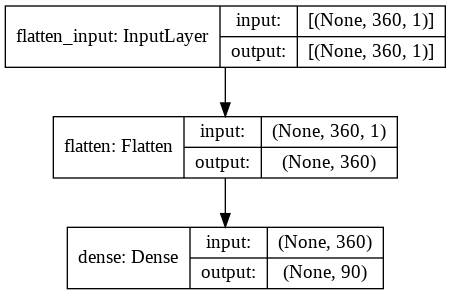

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=2000, restore_best_weights=True)

history = model.fit(ds_train, epochs=200, verbose=1, callbacks=[callback])

#przekazujemy zbiór danych, liczba epok, verbose - komunikaty, callbacks
#funkcja zwraca historię treningu
#callback - funkcja wczesnego zatrzymywania, ona monitoruje w naszym przypadku funkcje straty, czyli mse
# obserwuje czy funkcja straty spada, jeśli przez 20 epok z rzędu nie bedzie spadać, to zatrzyma trening
# restore - zostanie odtworzony najlepszy wynik
#callback będzie zatrzymywało trening

Epoch 1/200
223/223 [==============================] - 2s 7ms/step - loss: 0.0124 - mae: 0.0795
Epoch 2/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0120 - mae: 0.0760
Epoch 3/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0111 - mae: 0.0744
Epoch 4/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0106 - mae: 0.0736
Epoch 5/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0099 - mae: 0.0726
Epoch 6/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0096 - mae: 0.0720
Epoch 7/200
223/223 [==============================] - 2s 7ms/step - loss: 0.0094 - mae: 0.0711
Epoch 8/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0092 - mae: 0.0709
Epoch 9/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0092 - mae: 0.0704
Epoch 10/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0089 - mae: 0.0700
Epoch 11/200
223/223 [=================

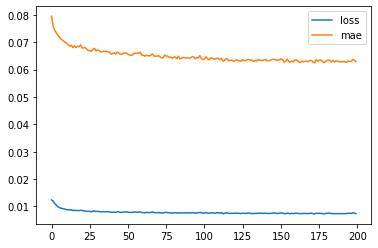

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model.evaluate(ds_test)

58/58 [==============================] - 0s 7ms/step - loss: 0.1165 - mae: 0.2808


[0.11648738384246826, 0.28077077865600586]

In [ ]:
def denormalize(x):
  return [i * (max - min) + min for i in x]

In [ ]:
def show_sample_predictions(model):
  for batch in ds_test.take(1):
    predictions = model.predict(batch[0]) #robi się dla całego batcha na raz
    for i in range(BATCH_SIZE): #dla wszystkich 16 batchy
      ts = range(WINDOW_SIZE + STEPS_AHEAD) #czas płynie w zakresie od 0 do, windows_size+steps_ahead
      xs = batch[0][i].numpy().reshape(-1) # z bierzemy z batcha, x są pierwsze 0, i-te wskazanie
      ys = batch[1][i].numpy()#ten numpy robi konwersje na numpy
      true = denormalize(np.concatenate((xs, ys), axis=0)) #to nwm co robi

      predicted = denormalize(predictions[i])#kolejne predykcje
      ts_predicted = range(WINDOW_SIZE, WINDOW_SIZE + STEPS_AHEAD)#czas trwania predykcji

      for i in range(3):
        print("Mean for {} month = {}".format(i, np.mean(predicted[10*i:10*(i+1)])))

      fig= plt.figure(figsize=(10,3))#a tutaj szerokość i długość wukresu
      plt.plot(ts, true, "b", ts_predicted, predicted, "g")
      
      plt.ylim(min,max) #zakres y od min do max
      plt.show()

Mean for 0 month = 27.498853172023512
Mean for 1 month = 26.13783098035598
Mean for 2 month = 25.458684265163647


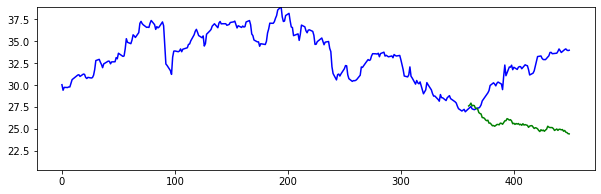

Mean for 0 month = 27.702355672586066
Mean for 1 month = 26.50762794005444
Mean for 2 month = 25.5053423031911


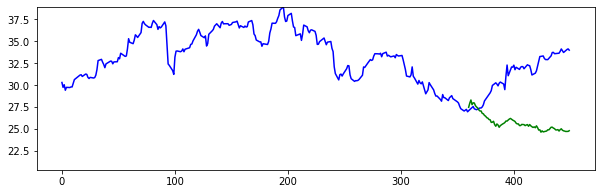

Mean for 0 month = 30.290208703399564
Mean for 1 month = 27.718102831988467
Mean for 2 month = 26.793596452635107


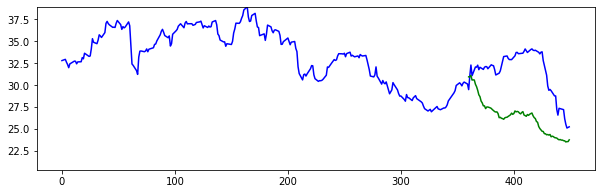

Mean for 0 month = 28.59316232258464
Mean for 1 month = 27.3687123262683
Mean for 2 month = 26.467230822164986


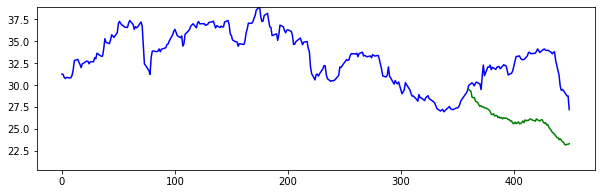

Mean for 0 month = 28.391564840924616
Mean for 1 month = 27.841841789208587
Mean for 2 month = 27.399442603031293


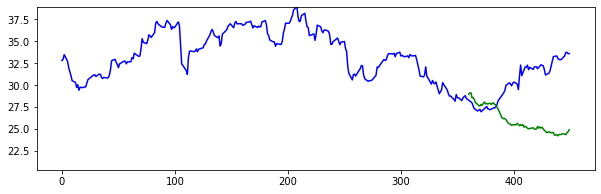

Mean for 0 month = 27.98065825035801
Mean for 1 month = 26.845174321073294
Mean for 2 month = 26.208771436238937


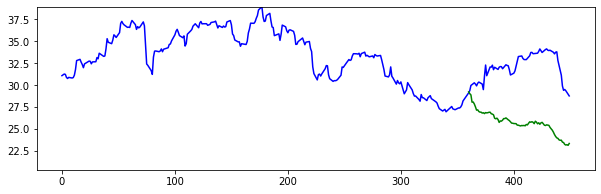

Mean for 0 month = 30.565058278072495
Mean for 1 month = 29.372100210323957
Mean for 2 month = 28.886897826971627


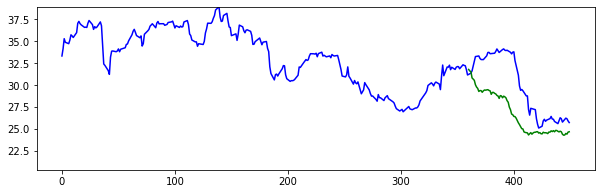

Mean for 0 month = 33.15718366299967
Mean for 1 month = 31.008505555388286
Mean for 2 month = 29.405673368290657


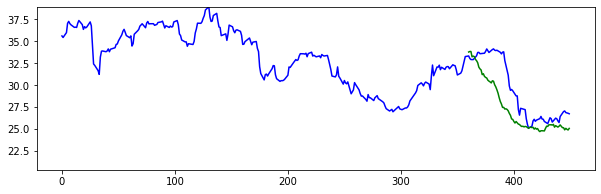

Mean for 0 month = 31.142891517672552
Mean for 1 month = 28.778633375373254
Mean for 2 month = 28.900147911321085


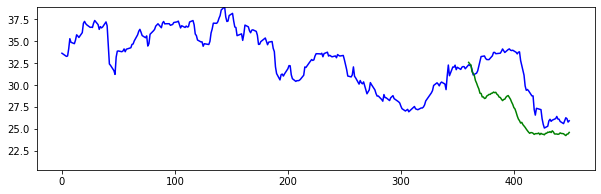

Mean for 0 month = 32.89371595230636
Mean for 1 month = 30.091511468631666
Mean for 2 month = 27.61132449635868


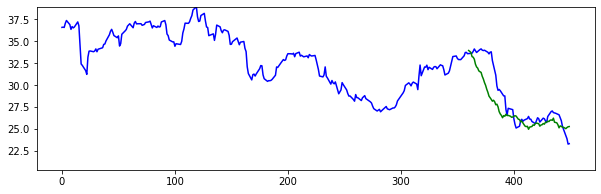

Mean for 0 month = 32.92935983374646
Mean for 1 month = 29.936003926805757
Mean for 2 month = 27.48861184020936


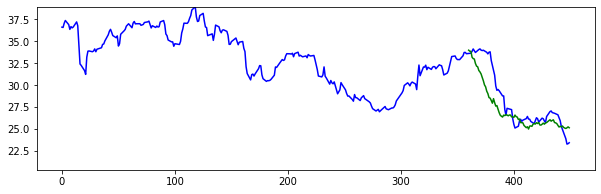

Mean for 0 month = 31.455503779933885
Mean for 1 month = 28.518390761458726
Mean for 2 month = 27.890723414704716


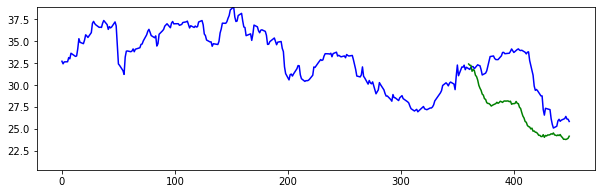

Mean for 0 month = 31.559744906763605
Mean for 1 month = 28.653940769170266
Mean for 2 month = 28.692642875493238


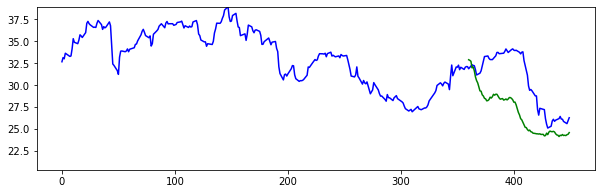

Mean for 0 month = 32.134114414991515
Mean for 1 month = 28.503590413849576
Mean for 2 month = 27.707262773595016


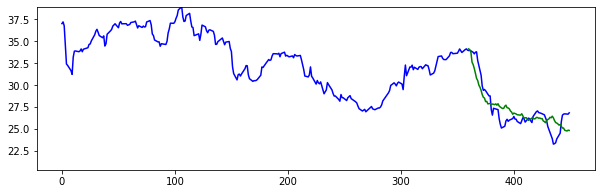

Mean for 0 month = 32.70770893055686
Mean for 1 month = 30.39236276420511
Mean for 2 month = 27.85422321695655


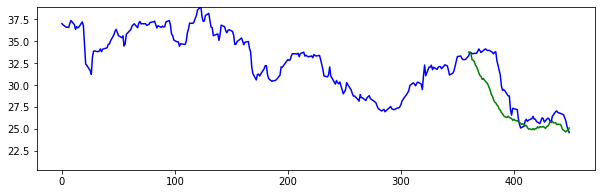

Mean for 0 month = 27.26092564413879
Mean for 1 month = 25.595990874735044
Mean for 2 month = 25.607444668172786


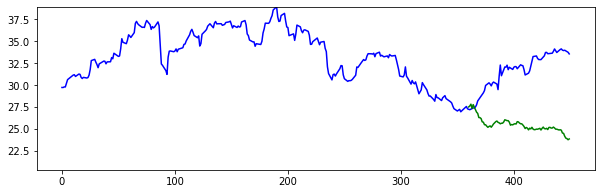

In [ ]:
show_sample_predictions(model)

#Siec (simple) RNN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8)                 80        
_________________________________________________________________
output (Dense)               (None, 90)                810       
Total params: 890
Trainable params: 890
Non-trainable params: 0
_________________________________________________________________


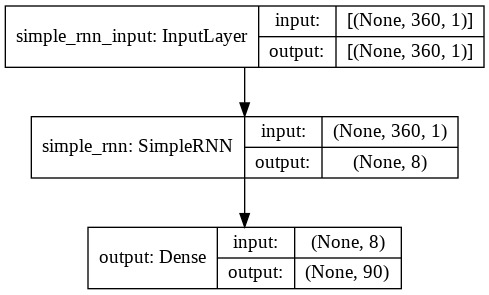

In [ ]:
def create_simple_rnn_model():
  model = Sequential([
                      SimpleRNN(8, input_shape=(WINDOW_SIZE, 1), return_sequences=False),
                      Dense(STEPS_AHEAD,name='output', activation='sigmoid')])

  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
  return model 

model = create_simple_rnn_model()

model.summary()
plot_model(model, show_shapes=True)



In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=500, restore_best_weights=True)

history = model.fit(ds_train, epochs=1000, verbose=1, callbacks=[callback])

Epoch 1/1000
223/223 [==============================] - 57s 252ms/step - loss: 0.0425 - mae: 0.1650
Epoch 2/1000
223/223 [==============================] - 56s 251ms/step - loss: 0.0363 - mae: 0.1555
Epoch 3/1000
223/223 [==============================] - 57s 257ms/step - loss: 0.0335 - mae: 0.1494
Epoch 4/1000
223/223 [==============================] - 57s 256ms/step - loss: 0.0294 - mae: 0.1410
Epoch 5/1000
223/223 [==============================] - 57s 255ms/step - loss: 0.0467 - mae: 0.1730
Epoch 6/1000
223/223 [==============================] - 57s 254ms/step - loss: 0.0222 - mae: 0.1228
Epoch 7/1000
223/223 [==============================] - 57s 256ms/step - loss: 0.0251 - mae: 0.1242
Epoch 8/1000
223/223 [==============================] - 57s 254ms/step - loss: 0.0171 - mae: 0.1001
Epoch 9/1000
223/223 [==============================] - 56s 253ms/step - loss: 0.0146 - mae: 0.0916
Epoch 10/1000
223/223 [==============================] - 57s 254ms/step - loss: 0.0127 - mae: 0.0835

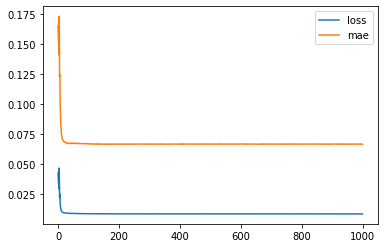

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model.evaluate(ds_test)

58/58 [==============================] - 2s 35ms/step - loss: 0.0389 - mae: 0.1629


[0.03888155519962311, 0.16287173330783844]

Mean for 0 month = 34.08948471643922
Mean for 1 month = 33.81165257066436
Mean for 2 month = 33.62879910534387


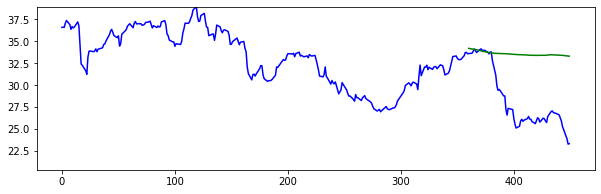

Mean for 0 month = 33.023455794111776
Mean for 1 month = 32.779300309125134
Mean for 2 month = 32.616046898517716


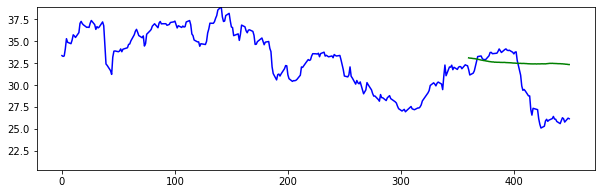

Mean for 0 month = 28.5897114317881
Mean for 1 month = 28.58020679325734
Mean for 2 month = 28.56392738921685


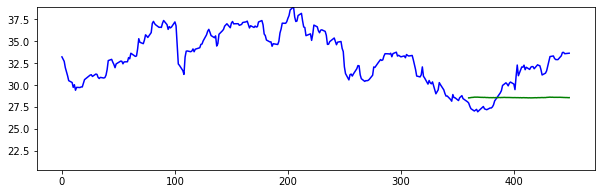

Mean for 0 month = 34.00509067253893
Mean for 1 month = 33.73064343590155
Mean for 2 month = 33.53825314723095


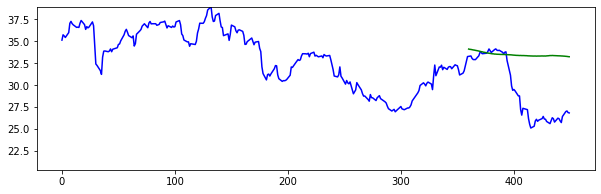

Mean for 0 month = 32.57302240986443
Mean for 1 month = 32.34254608456526
Mean for 2 month = 32.19838055090636


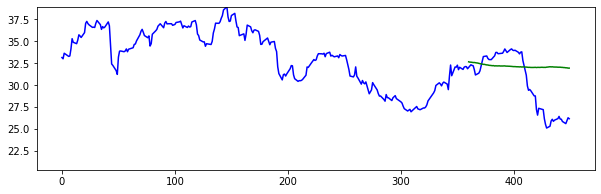

Mean for 0 month = 32.96528654137127
Mean for 1 month = 32.725779789448126
Mean for 2 month = 32.56383745163797


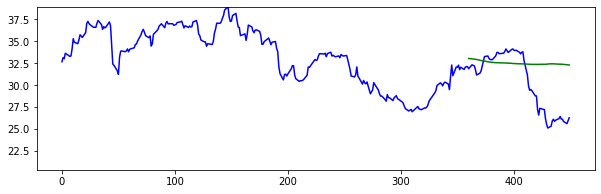

Mean for 0 month = 32.820395932092616
Mean for 1 month = 32.588985413228166
Mean for 2 month = 32.431449227217726


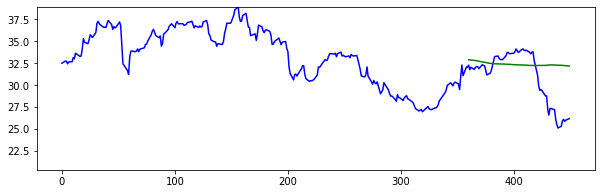

Mean for 0 month = 34.15844861306986
Mean for 1 month = 33.88000701244258
Mean for 2 month = 33.6910011882142


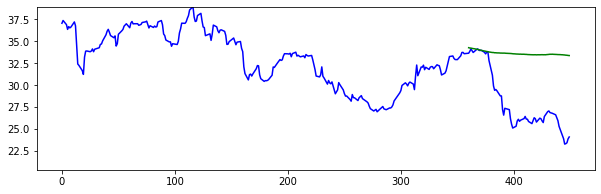

Mean for 0 month = 30.924056035754425
Mean for 1 month = 30.780406570943576
Mean for 2 month = 30.678904655735316


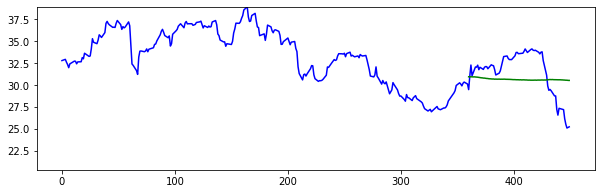

Mean for 0 month = 32.73446346494391
Mean for 1 month = 32.503328323618554
Mean for 2 month = 32.32488923696009


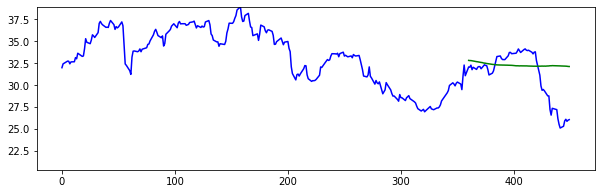

Mean for 0 month = 33.61233092816595
Mean for 1 month = 33.34862441611856
Mean for 2 month = 33.16994397110828


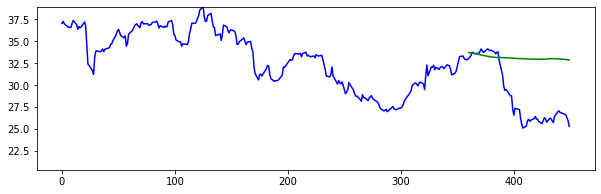

Mean for 0 month = 27.596728875329386
Mean for 1 month = 27.643803759575214
Mean for 2 month = 27.662119034098186


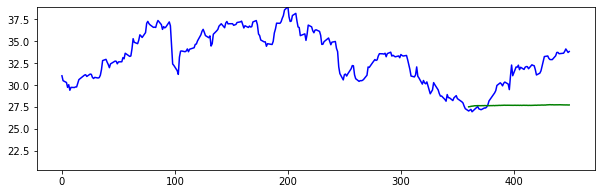

Mean for 0 month = 29.483922501928657
Mean for 1 month = 29.426094274864873
Mean for 2 month = 29.367789167722748


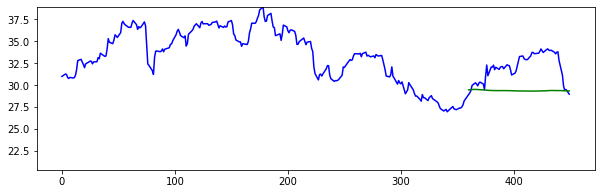

Mean for 0 month = 34.31833857108604
Mean for 1 month = 34.03315283333499
Mean for 2 month = 33.84744019984693


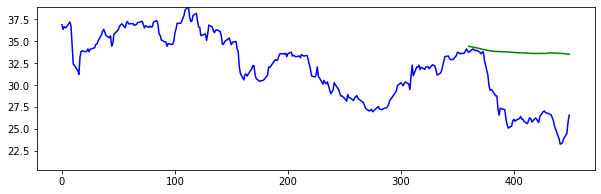

Mean for 0 month = 31.279329637403173
Mean for 1 month = 31.116159829504436
Mean for 2 month = 30.999016981473762


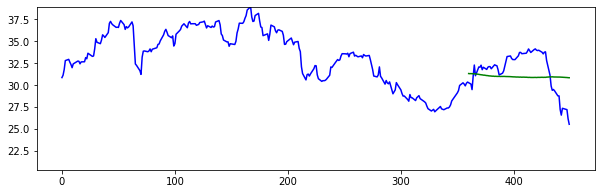

Mean for 0 month = 32.994254435236044
Mean for 1 month = 32.761046013439554
Mean for 2 month = 32.58545742339109


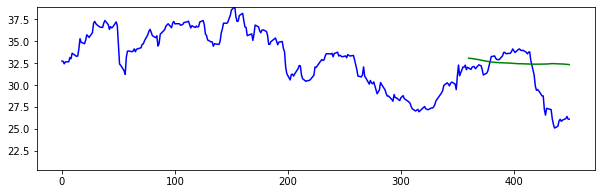

In [ ]:
show_sample_predictions(model)

##Sieć rekurencyjna

In [ ]:
def create_model():
  model = Sequential([
                      LSTM(36, input_shape=(WINDOW_SIZE, 1), return_sequences=True),
                      LSTM(10, return_sequences=False),
                      Dense(STEPS_AHEAD,  name='output', activation='sigmoid')])

  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
  return model 

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 360, 36)           5472      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1880      
_________________________________________________________________
output (Dense)               (None, 90)                990       
Total params: 8,342
Trainable params: 8,342
Non-trainable params: 0
_________________________________________________________________


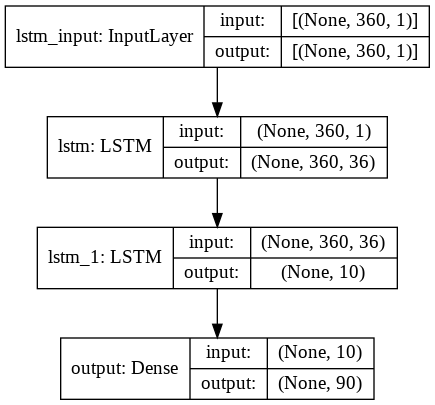

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=500, restore_best_weights=True)

history = model.fit(ds_train, epochs=1000, verbose=1,  callbacks=[callback])

Epoch 1/1000
223/223 [==============================] - 10s 25ms/step - loss: 0.0381 - mae: 0.1544
Epoch 2/1000
223/223 [==============================] - 6s 25ms/step - loss: 0.0381 - mae: 0.1584
Epoch 3/1000
223/223 [==============================] - 6s 25ms/step - loss: 0.0365 - mae: 0.1551
Epoch 4/1000
223/223 [==============================] - 6s 25ms/step - loss: 0.0350 - mae: 0.1512
Epoch 5/1000
223/223 [==============================] - 6s 25ms/step - loss: 0.0366 - mae: 0.1557
Epoch 6/1000
223/223 [==============================] - 6s 25ms/step - loss: 0.0350 - mae: 0.1524
Epoch 7/1000
223/223 [==============================] - 6s 25ms/step - loss: 0.0347 - mae: 0.1518
Epoch 8/1000
223/223 [==============================] - 6s 25ms/step - loss: 0.0346 - mae: 0.1514
Epoch 9/1000
223/223 [==============================] - 6s 25ms/step - loss: 0.0345 - mae: 0.1510
Epoch 10/1000
223/223 [==============================] - 6s 25ms/step - loss: 0.0344 - mae: 0.1506
Epoch 11/1000
223/

In [ ]:
model.evaluate(ds_test)

58/58 [==============================] - 2s 12ms/step - loss: 0.0513 - mae: 0.1900


[0.05134148895740509, 0.19002652168273926]

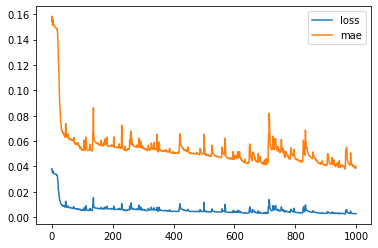

In [ ]:
pd.DataFrame(history.history).plot()

Mean for 0 month = 34.688651988740894
Mean for 1 month = 35.587716073829526
Mean for 2 month = 35.643682083909454


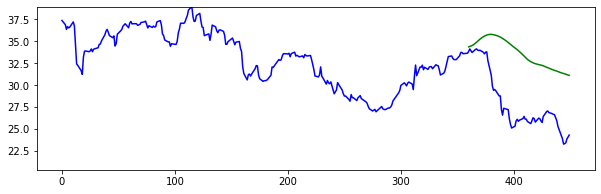

Mean for 0 month = 26.195420906347856
Mean for 1 month = 26.413234367387055
Mean for 2 month = 25.903761017082132


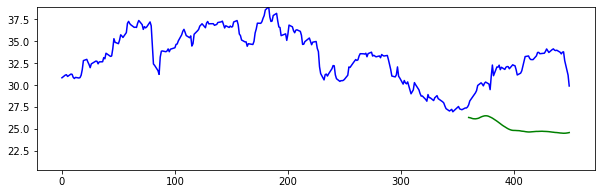

Mean for 0 month = 34.729586632024635
Mean for 1 month = 35.60689733678245
Mean for 2 month = 35.615765227289266


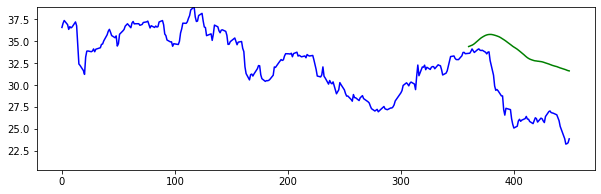

Mean for 0 month = 34.66924860050612
Mean for 1 month = 35.937791521422334
Mean for 2 month = 36.481640815810216


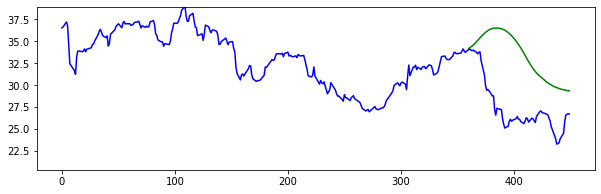

Mean for 0 month = 26.80637888433285
Mean for 1 month = 26.86949526065562
Mean for 2 month = 26.174942856432864


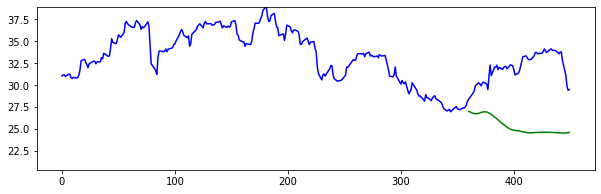

Mean for 0 month = 31.9915962549195
Mean for 1 month = 29.746967418604516
Mean for 2 month = 27.31406972927909


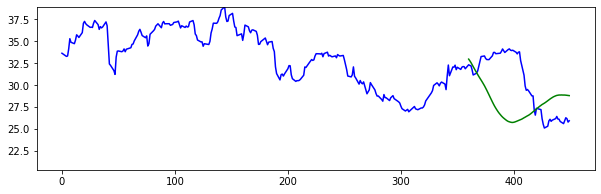

Mean for 0 month = 34.71264240857198
Mean for 1 month = 35.59783833848809
Mean for 2 month = 35.62630461610075


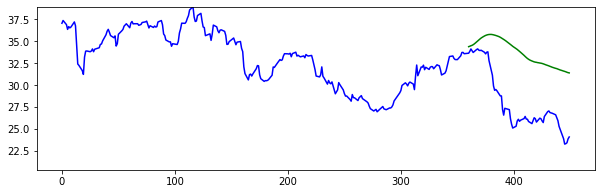

Mean for 0 month = 28.25513989529105
Mean for 1 month = 27.385796851075167
Mean for 2 month = 26.95299630088899


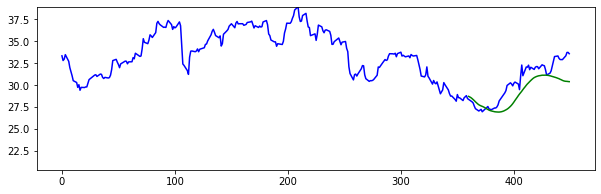

Mean for 0 month = 28.560650040745134
Mean for 1 month = 27.764088101676
Mean for 2 month = 27.426800088602608


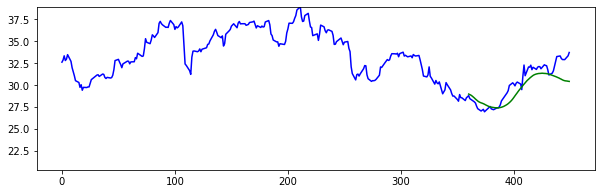

Mean for 0 month = 25.91756296824797
Mean for 1 month = 26.26968101233905
Mean for 2 month = 25.93252668577789


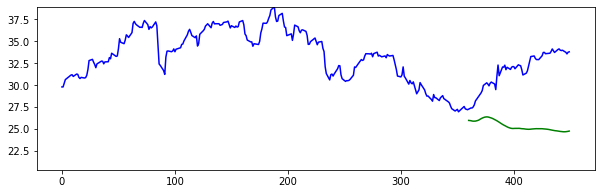

Mean for 0 month = 26.089654141258414
Mean for 1 month = 26.35779204156148
Mean for 2 month = 25.911436068143654


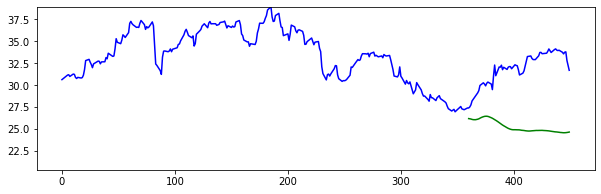

Mean for 0 month = 25.866137241175256
Mean for 1 month = 26.509249632490103
Mean for 2 month = 26.59760268710723


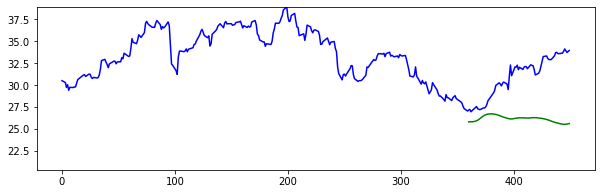

Mean for 0 month = 32.638701009095584
Mean for 1 month = 30.34084298408512
Mean for 2 month = 27.725040022441544


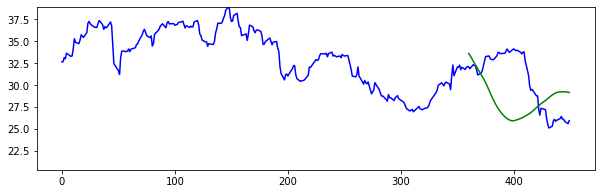

Mean for 0 month = 26.067008257542835
Mean for 1 month = 26.32328646881053
Mean for 2 month = 25.864136946313486


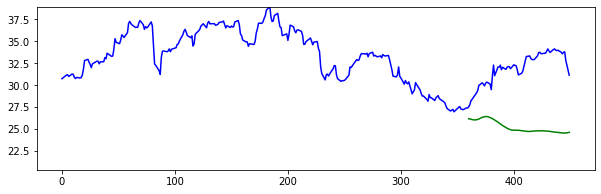

Mean for 0 month = 26.392683443036496
Mean for 1 month = 26.55629327689399
Mean for 2 month = 25.98079485416426


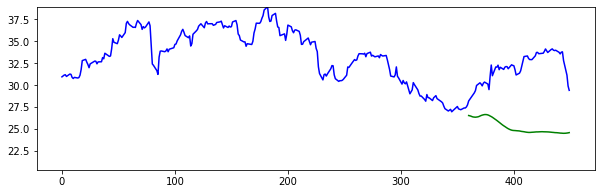

Mean for 0 month = 30.777625446793955
Mean for 1 month = 28.67878177985795
Mean for 2 month = 26.58199538436377


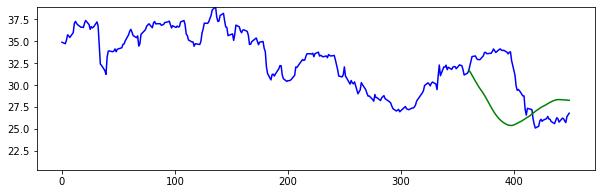

In [ ]:
show_sample_predictions(model)

## Model Dawida

In [ ]:
def create_model_Dawida():
  model = Sequential([
                      LSTM(50, input_shape=(WINDOW_SIZE, 1), return_sequences=True),
                      LSTM(50, return_sequences=True),
                      LSTM(500, return_sequences=False),
                      Dense(STEPS_AHEAD,  name='output', activation='sigmoid')])

  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
  return model 



In [ ]:
model = create_model_Dawida()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 360, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 360, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 500)               1102000   
_________________________________________________________________
output (Dense)               (None, 90)                45090     
Total params: 1,177,690
Trainable params: 1,177,690
Non-trainable params: 0
_________________________________________________________________


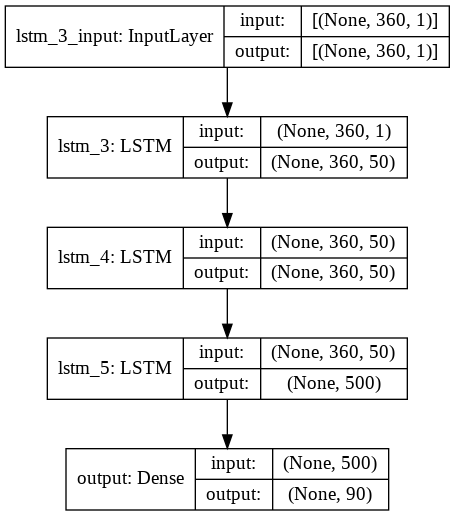

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=100, restore_best_weights=True)

history = model.fit(ds_train, epochs=200, verbose=1,  callbacks=[callback])

Epoch 1/200
223/223 [==============================] - 447s 2s/step - loss: 0.0094 - mae: 0.0669
Epoch 2/200
223/223 [==============================] - 422s 2s/step - loss: 0.0127 - mae: 0.0753
Epoch 3/200
223/223 [==============================] - 431s 2s/step - loss: 0.0260 - mae: 0.1256
Epoch 4/200
223/223 [==============================] - 428s 2s/step - loss: 0.0144 - mae: 0.0901
Epoch 5/200
223/223 [==============================] - 435s 2s/step - loss: 0.0145 - mae: 0.0909
Epoch 6/200
223/223 [==============================] - 428s 2s/step - loss: 0.0153 - mae: 0.0908
Epoch 7/200
223/223 [==============================] - 432s 2s/step - loss: 0.0123 - mae: 0.0750
Epoch 8/200
223/223 [==============================] - 419s 2s/step - loss: 0.0280 - mae: 0.1077
Epoch 9/200
223/223 [==============================] - 421s 2s/step - loss: 0.0344 - mae: 0.1243
Epoch 10/200
223/223 [==============================] - 425s 2s/step - loss: 0.0352 - mae: 0.1390
Epoch 11/200
223/223 [=======

In [ ]:
model.evaluate(ds_test)

29/29 [==============================] - 2s 31ms/step - loss: 0.0968 - mae: 0.2664


[0.09679259359836578, 0.26642656326293945]

In [ ]:
pd.DataFrame(history.history).plot()

NameError: ignored

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.170235201247557


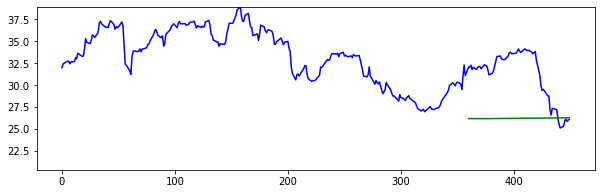

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.17023520124756


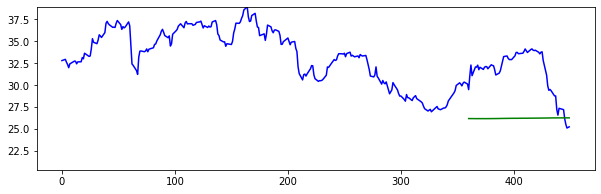

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.170235145660648


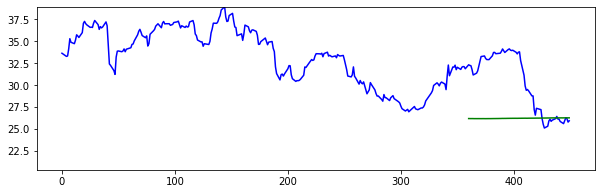

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.170235201247557


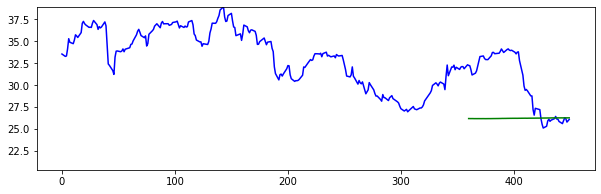

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.170235145660648


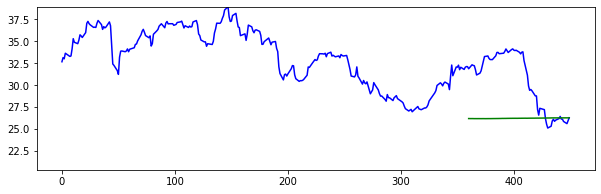

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.170235312421376


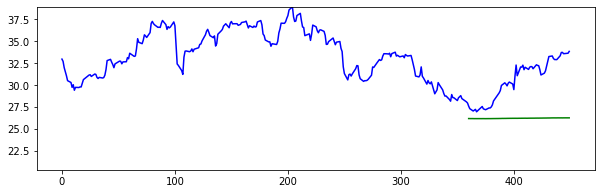

Mean for 0 month = 26.162360815536196
Mean for 1 month = 26.15962499471609
Mean for 2 month = 26.170235201247557


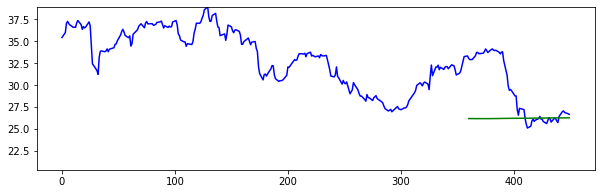

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.17023520124756


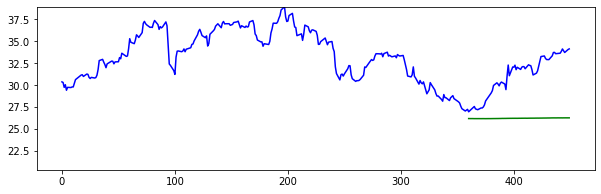

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.170235145660648


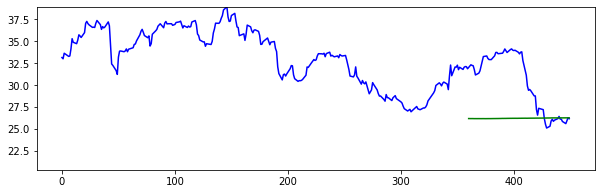

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.17023520124756


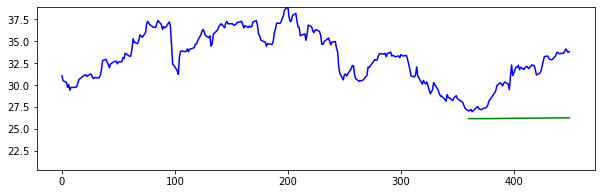

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.17023520124756


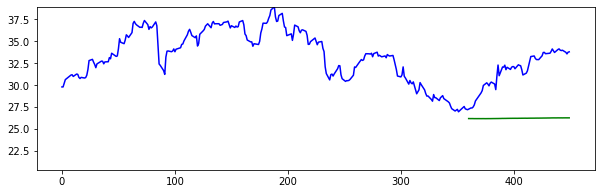

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.170235256834466


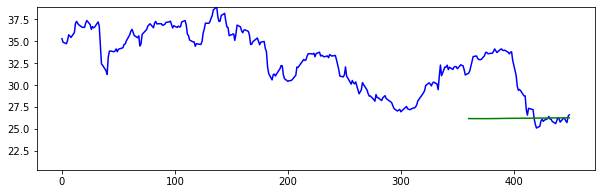

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.17023520124756


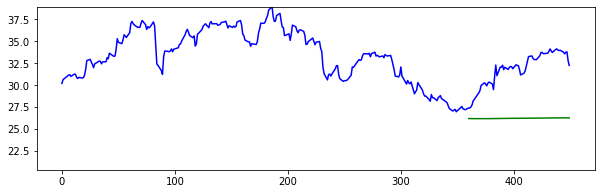

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.170235145660648


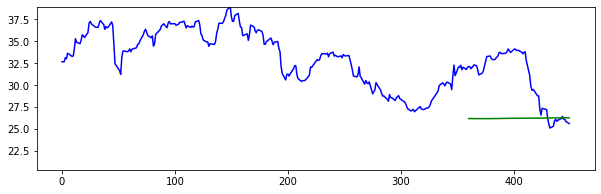

Mean for 0 month = 26.162360871123106
Mean for 1 month = 26.159625050303
Mean for 2 month = 26.170235256834463


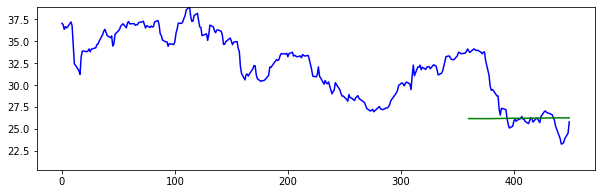

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.170235201247557


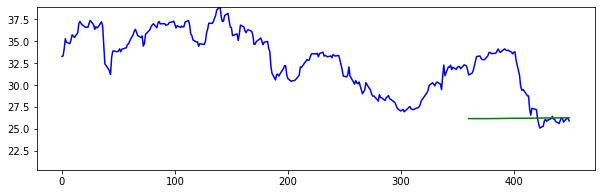

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.17023520124756


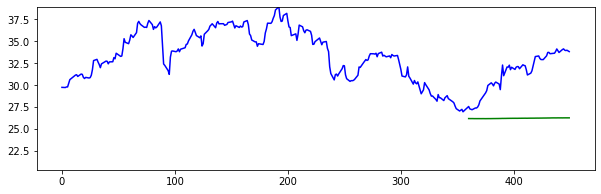

Mean for 0 month = 26.162360871123106
Mean for 1 month = 26.15962499471609
Mean for 2 month = 26.170235256834463


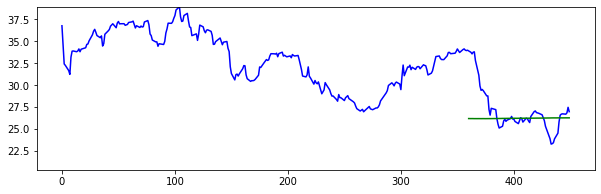

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.17023520124756


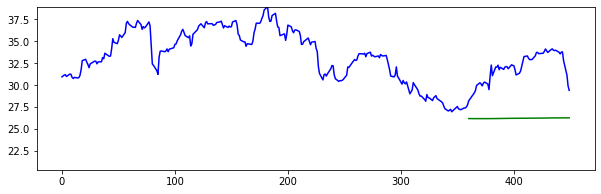

Mean for 0 month = 26.162360871123106
Mean for 1 month = 26.15962499471609
Mean for 2 month = 26.170235256834463


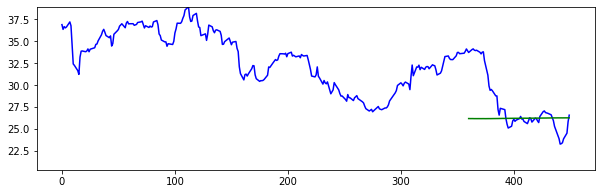

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.17023520124756


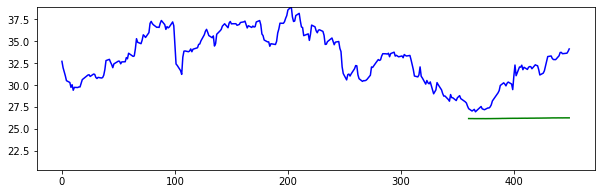

Mean for 0 month = 26.162360815536196
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.170235256834463


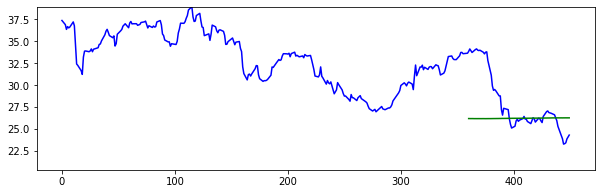

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.170235256834466


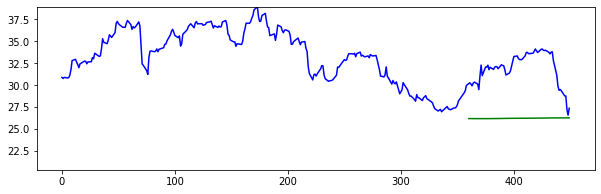

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.170235312421376


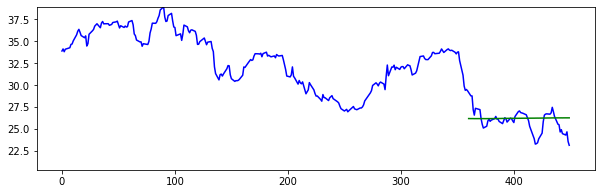

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.159624772368453
Mean for 2 month = 26.17023520124756


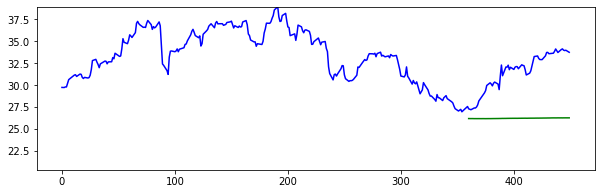

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.17023520124756


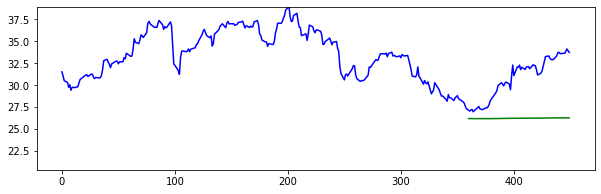

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.170235201247557


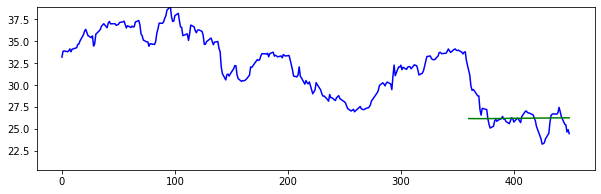

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.170235312421376


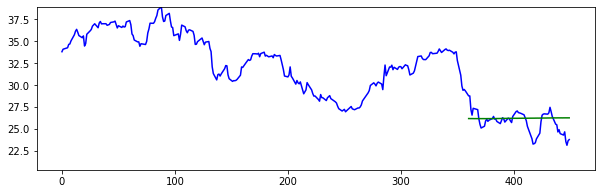

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.17023520124756


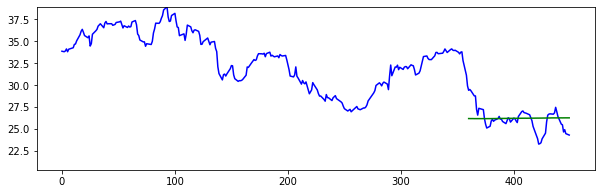

Mean for 0 month = 26.16236064877548
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.170235312421376


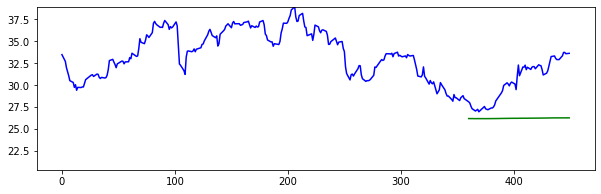

Mean for 0 month = 26.16236075994929
Mean for 1 month = 26.159624827955366
Mean for 2 month = 26.170235145660648


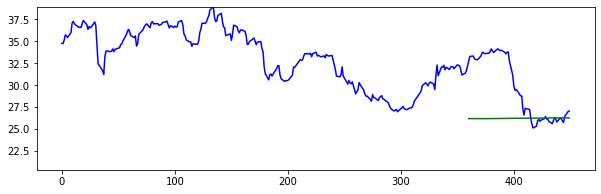

Mean for 0 month = 26.162360704362385
Mean for 1 month = 26.15962488354228
Mean for 2 month = 26.17023520124756


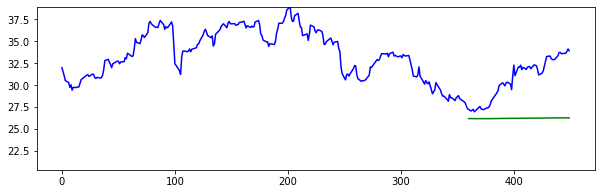

In [ ]:
show_sample_predictions(model)

# Drugi model Dawida

In [ ]:
# Building model
model = Sequential()
model.add(LSTM(units=50,return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(STEPS_AHEAD))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(ds_train,epochs=25,verbose=1,  callbacks=[callback])

Epoch 1/25
112/112 [==============================] - 9s 45ms/step - loss: 0.0166
Epoch 2/25
112/112 [==============================] - 5s 45ms/step - loss: 0.0214
Epoch 3/25
112/112 [==============================] - 5s 45ms/step - loss: 0.0373
Epoch 4/25
112/112 [==============================] - 5s 45ms/step - loss: 0.0384
Epoch 5/25
112/112 [==============================] - 5s 44ms/step - loss: 0.0373
Epoch 6/25
112/112 [==============================] - 5s 44ms/step - loss: 0.0378
Epoch 7/25
112/112 [==============================] - 5s 44ms/step - loss: 0.0321
Epoch 8/25
112/112 [==============================] - 5s 44ms/step - loss: 0.0261
Epoch 9/25
112/112 [==============================] - 5s 46ms/step - loss: 0.0422
Epoch 10/25
112/112 [==============================] - 5s 46ms/step - loss: 0.0445
Epoch 11/25
112/112 [==============================] - 5s 45ms/step - loss: 0.0415
Epoch 12/25
112/112 [==============================] - 5s 45ms/step - loss: 0.0388
Epoch 13/25
1

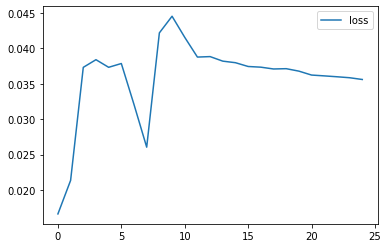

In [ ]:
pd.DataFrame(history.history).plot()

Mean for 0 month = 26.875363236945397
Mean for 1 month = 26.9530121987445
Mean for 2 month = 26.95721690359191


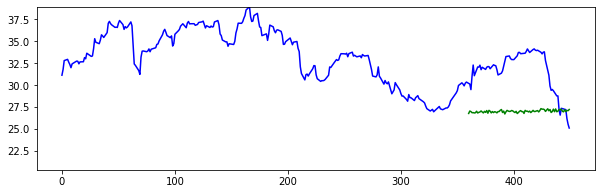

Mean for 0 month = 26.875263291685947
Mean for 1 month = 26.95296122555044
Mean for 2 month = 26.95710434010448


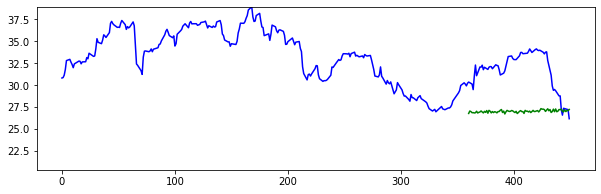

Mean for 0 month = 26.873624923178074
Mean for 1 month = 26.951673276906643
Mean for 2 month = 26.955401212849516


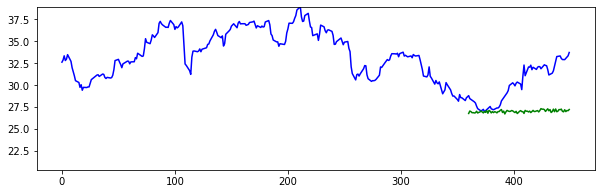

Mean for 0 month = 26.877819844729782
Mean for 1 month = 26.954976917985555
Mean for 2 month = 26.95989180116154


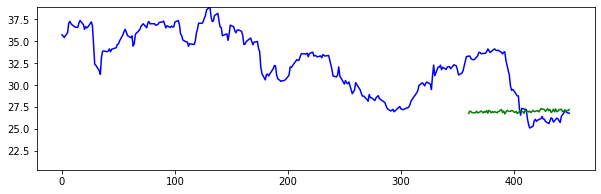

Mean for 0 month = 26.873463887907416
Mean for 1 month = 26.951513798069392
Mean for 2 month = 26.955234063019056


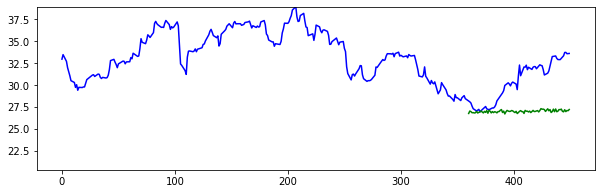

Mean for 0 month = 26.8733151929302
Mean for 1 month = 26.951511852527638
Mean for 2 month = 26.95506963694705


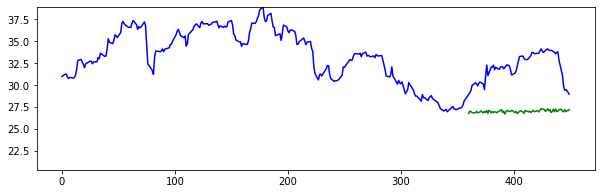

Mean for 0 month = 26.873713417534606
Mean for 1 month = 26.951752877357997
Mean for 2 month = 26.955493598289575


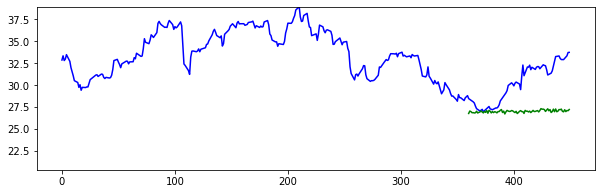

Mean for 0 month = 26.877077703929462
Mean for 1 month = 26.954327774081264
Mean for 2 month = 26.95908173316041


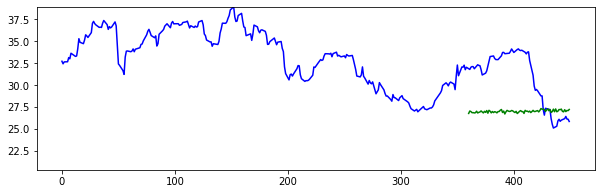

Mean for 0 month = 26.878524353193807
Mean for 1 month = 26.95546402605485
Mean for 2 month = 26.96068302520107


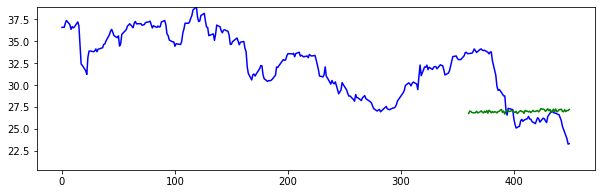

Mean for 0 month = 26.878061425429216
Mean for 1 month = 26.955093428143403
Mean for 2 month = 26.960174404998618


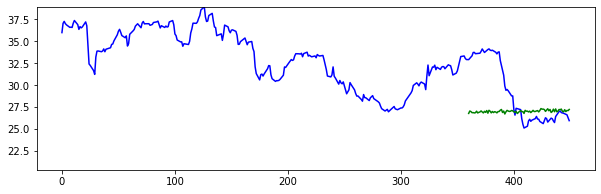

Mean for 0 month = 26.878206562844365
Mean for 1 month = 26.955217164599212
Mean for 2 month = 26.96032371143182


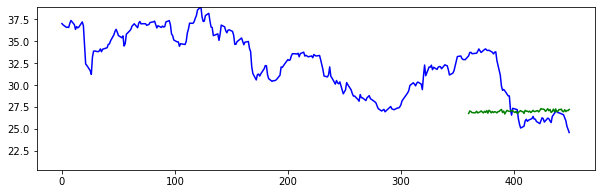

Mean for 0 month = 26.87203841725478
Mean for 1 month = 26.950441582213095
Mean for 2 month = 26.95374566798727


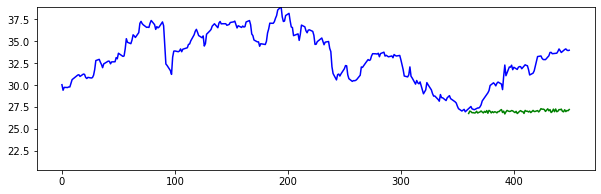

Mean for 0 month = 26.87224825783011
Mean for 1 month = 26.950643418273767
Mean for 2 month = 26.953968627072737


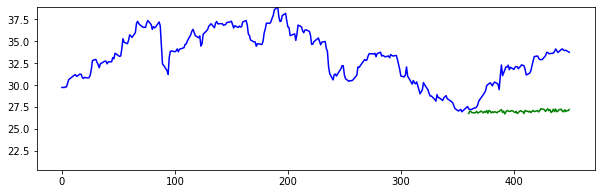

Mean for 0 month = 26.878028795914588
Mean for 1 month = 26.955083422500074
Mean for 2 month = 26.96014433248173


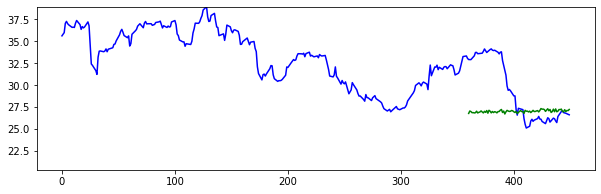

Mean for 0 month = 26.877242574696727
Mean for 1 month = 26.95445273344904
Mean for 2 month = 26.95925466402925


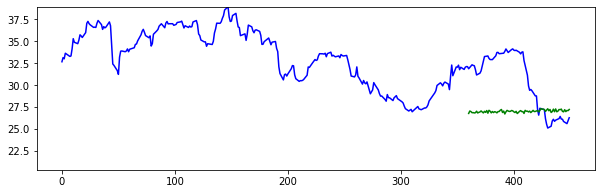

Mean for 0 month = 26.87709104478723
Mean for 1 month = 26.954400815277552
Mean for 2 month = 26.959080565835357


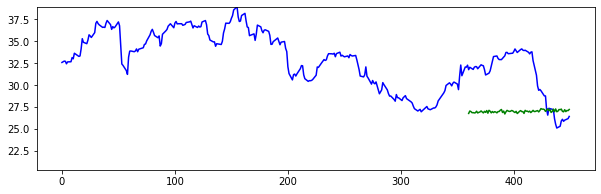

Mean for 0 month = 26.87330796663224
Mean for 1 month = 26.951383947053774
Mean for 2 month = 26.955066079384977


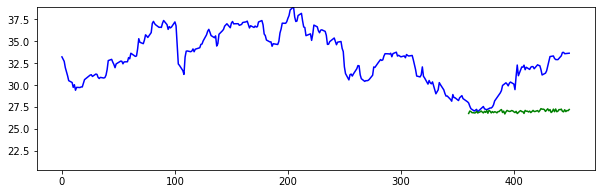

Mean for 0 month = 26.87738104168299
Mean for 1 month = 26.954556736552735
Mean for 2 month = 26.95941186380329


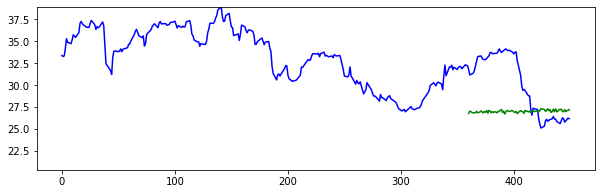

Mean for 0 month = 26.87716664298126
Mean for 1 month = 26.954347118325035
Mean for 2 month = 26.959193907539486


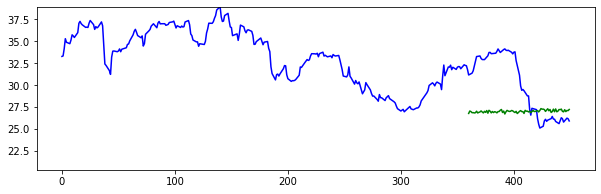

Mean for 0 month = 26.877064140724066
Mean for 1 month = 26.954299146823974
Mean for 2 month = 26.95906450121913


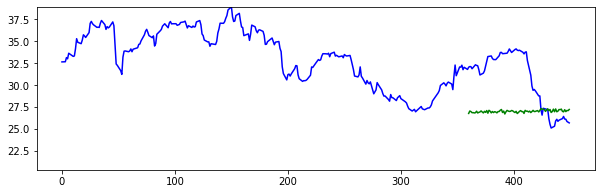

Mean for 0 month = 26.87215464947809
Mean for 1 month = 26.95055981556508
Mean for 2 month = 26.95387023824669


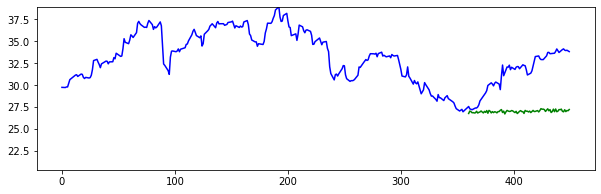

Mean for 0 month = 26.877294214933677
Mean for 1 month = 26.954494757151014
Mean for 2 month = 26.959310195349712


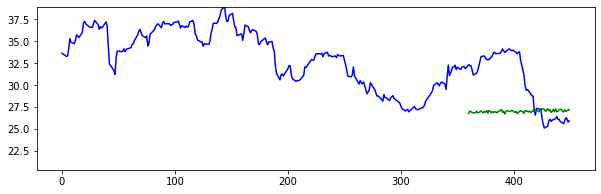

Mean for 0 month = 26.878768212956448
Mean for 1 month = 26.955661637510552
Mean for 2 month = 26.960946951837265


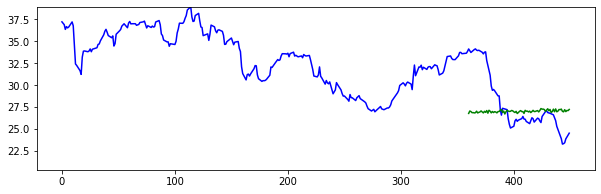

Mean for 0 month = 26.878526076387935
Mean for 1 month = 26.955482536495005
Mean for 2 month = 26.960678355900846


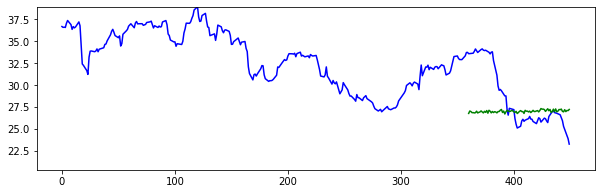

Mean for 0 month = 26.87860545449167
Mean for 1 month = 26.95552333728502
Mean for 2 month = 26.96077285364338


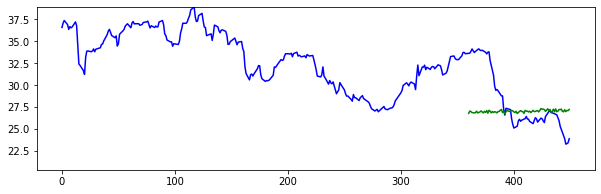

Mean for 0 month = 26.87210022989577
Mean for 1 month = 26.95049194395118
Mean for 2 month = 26.95381426223097


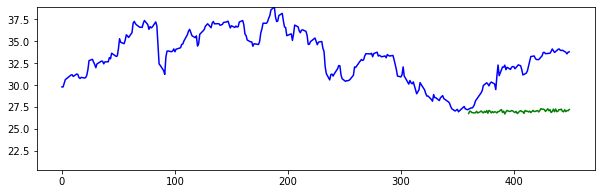

Mean for 0 month = 26.87534389270163
Mean for 1 month = 26.9530152004375
Mean for 2 month = 26.957193668264626


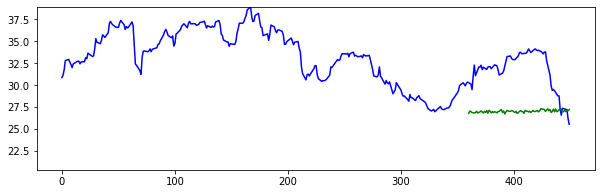

Mean for 0 month = 26.87882674596991
Mean for 1 month = 26.955692655004874
Mean for 2 month = 26.96102649670172


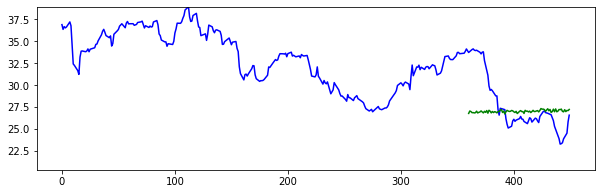

Mean for 0 month = 26.878582052403658
Mean for 1 month = 26.95550916262364
Mean for 2 month = 26.960744226386083


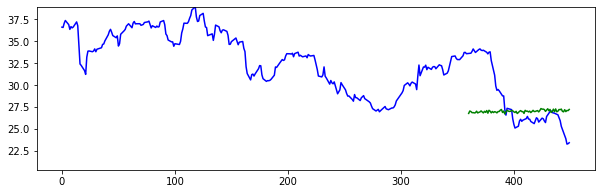

Mean for 0 month = 26.875524105455337
Mean for 1 month = 26.952940825155434
Mean for 2 month = 26.957400562733863


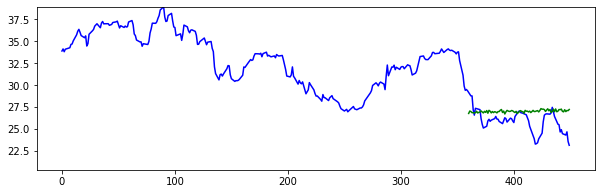

Mean for 0 month = 26.872196562006252
Mean for 1 month = 26.950538414605738
Mean for 2 month = 26.953901422501723


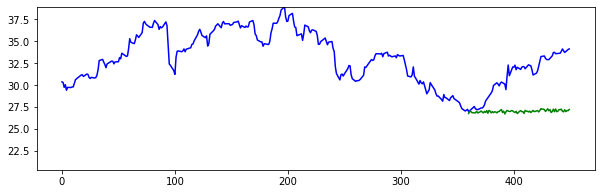

Mean for 0 month = 26.87884358880284
Mean for 1 month = 26.955693155287037
Mean for 2 month = 26.961043728643


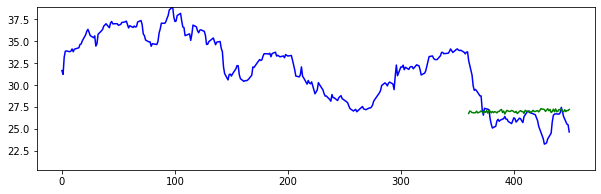

In [ ]:
show_sample_predictions(model)

In [ ]:
#Wskazówka jest taka, że można ogólnie wykonać model, który będzie predykował
#tylko 1 dzień w przód, ale użyjemy go 90 razy,
#z tym, że to użycie nie będzie takie samo, będzie się odcinało pierwszy
#dzień z lewej i dodawało predykowaną wartość z prawej

#Konsumpcja swoich własnych predykcji
#czyli w ostanim użyciu model dostaje swoje 89 predykcji

In [ ]:
#Stworzenie modelu odniesienia
#on mógłby przewidywać, że cena się nie zmieni
#czyli każdego następnego dnia cena będzie taka jak poprzedniego
#mała funckja straty, on miałby ma naprawdę mae i mse